# **hkl_soleil** E4CH

The [IUCr provides a schematic of the 4-circle diffractometer](http://ww1.iucr.org/iucr-top/comm/cteach/pamphlets/2/node14.html) (in horizontal geometry typical of a laboratory instrument).  In **hklpy2**, this is the *E4CH* [geometry](../geometry_tables.rst).

<!-- image source:
  http://ww1.iucr.org/iucr-top/comm/cteach/pamphlets/2/
  -->
![E4CH geometry](../_static/img69-iucr-4-circle.gif)

**Note**: At X-ray synchrotrons, the vertical *E4CV* geometry is more common
due to the polarization of the X-rays.

## Setup the *E4CH* diffractometer in **hklpy2**

The *hkl_soleil* *E4CH* [geometry](https://people.debian.org/~picca/hkl/hkl.html)
is described:

axis  | moves    | rotation axis    | vector
---   | ---      | ---              | ---
omega | sample   | $\vec{z}$        | `[0 0 1]`
chi   | sample   | $\vec{x}$        | `[1 0 0]`
phi   | sample   | $\vec{z}$        | `[0 0 1]`
tth   | detector | $\vec{z}$        | `[0 0 1]`

* xrays incident on the $\vec{x}$ direction (1, 0, 0)

## Define _this_ diffractometer

Use the **hklpy2** `creator()` function to create a diffractometer
object.  The diffractometer object will have simulated rotational axes.

We'll provide the geometry and solver names.
By convention, the `name` keyword is the same as the object name.

See the [geometry tables](../geometry_tables.rst) for
a more complete description of the available diffractometers.

Create the Python diffractometer object (`fourc`).

In [1]:
import hklpy2

fourc = hklpy2.creator(name="fourc", geometry="E4CH", solver="hkl_soleil")

## Add a sample with a crystal structure

In [2]:
from hklpy2.user import *

set_diffractometer(fourc)
add_sample("silicon", a=hklpy2.SI_LATTICE_PARAMETER)

Sample(name='silicon', lattice=Lattice(a=5.431, system='cubic'))

## Setup the UB orientation matrix using *hklpy*

Define the crystal's orientation on the diffractometer using 
the 2-reflection method described by [Busing & Levy, Acta Cryst 22 (1967) 457](https://www.psi.ch/sites/default/files/import/sinq/zebra/PracticalsEN/1967-Busing-Levy-3-4-circle-Acta22.pdf).

Use the same X-ray wavelength for both reflections.  This is an ophyd Signal. Use its `.put()` method.

In [3]:
fourc.wavelength.put(1.54)

### Specify the first reflection

Provide the set of angles that correspond with the reflection's Miller indices: (_hkl_)

The `setor()` (set orienting reflection) method uses the diffractometer's wavelength *at the time it is called*.  (To add reflections at different wavelengths, add a `wavelength=1.0` keyword argument with the correct value.)  

In [4]:
r1 = setor(4, 0, 0, tth=69.0966, omega=-145.451, chi=0, phi=0)

### Specify the second reflection

In [5]:
r2 = setor(0, 4, 0, tth=69.0966, omega=-145.451, chi=90, phi=0)

### Compute the *UB* orientation matrix

The `calc_UB()` method returns the computed **UB** matrix.

In [6]:
calc_UB(r1, r2)

[[-1.4134285e-05, -1.4134285e-05, -1.156906937382],
 [-1.156906937469, 1.73e-10, 1.4134285e-05],
 [0.0, 1.156906937469, -1.4134285e-05]]

## Report our setup

In [7]:
pa()

diffractometer='fourc'
HklSolver(name='hkl_soleil', version='5.1.2', geometry='E4CH', engine_name='hkl', mode='bissector')
Sample(name='silicon', lattice=Lattice(a=5.431, system='cubic'))
Reflection(name='r_c62e', h=4, k=0, l=0)
Reflection(name='r_0518', h=0, k=4, l=0)
Orienting reflections: ['r_c62e', 'r_0518']
U=[[-1.2217305e-05, -1.2217305e-05, -0.999999999851], [-0.999999999925, 1.49e-10, 1.2217305e-05], [0.0, 0.999999999925, -1.2217305e-05]]
UB=[[-1.4134285e-05, -1.4134285e-05, -1.156906937382], [-1.156906937469, 1.73e-10, 1.4134285e-05], [0.0, 1.156906937469, -1.4134285e-05]]
constraint: -180.0 <= omega <= 180.0
constraint: -180.0 <= chi <= 180.0
constraint: -180.0 <= phi <= 180.0
constraint: -180.0 <= tth <= 180.0
h=0, k=0, l=0
wavelength=1.54
omega=0, chi=0, phi=0, tth=0


## Check the orientation matrix

Perform checks with `forward()` (hkl to angle) and
`inverse()` (angle to hkl) computations to verify the diffractometer
will move to the same positions where the reflections were identified.

### Constrain the motors to limited ranges

* keep `tth` in the positive range
* keep `omega` in the negative range
* allow for slight roundoff errors
* keep `phi` fixed at zero

First, we apply constraints directly to the `calc`-level support.

In [8]:
fourc.core.constraints["tth"].limits = -0.001, 180
fourc.core.constraints["omega"].limits = (-180, 0.001)
fourc.core.constraints

['-180.0 <= omega <= 0.001', '-180.0 <= chi <= 180.0', '-180.0 <= phi <= 180.0', '-0.001 <= tth <= 180.0']

### (400) reflection test

1. Check the `inverse()` (angles -> (_hkl_)) computation.
1. Check the `forward()` ((_hkl_) -> angles) computation.

#### Check the inverse calculation: (400)

To calculate the (_hkl_) corresponding to a given set of motor angles,
call `fourc.inverse()`.

The _hkl_ values are provided as a Python [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) structure.

In [9]:
fourc.inverse((-145.451, 0, 0, 69.0966))

Hklpy2DiffractometerPseudoPos(h=3.999916764257, k=0, l=0)

#### Check the forward calculation: (400)

Compute the angles necessary to position the diffractometer
for the given reflection.

Note that for the forward computation, more than one set of angles may be used to reach the same crystal reflection.  This test will report the *default* selection.  The *default* selection (which may be changed through methods described in the `hkl.calc` module) is the first solution.

function | returns
--- | ---
`fourc.forward()` | The *default* solution
`fourc.calc.forward()` | List of all allowed solutions.

Here we print the *default* solution (the one returned by calling 
`cahkl()`.  This command is a shortcut to `fourc.forward()`).

In [10]:
cahkl(4, 0, 0)

Hklpy2DiffractometerRealPos(omega=-145.450879077739, chi=0, phi=0.000699999914, tth=69.098241844523)

Show the table of all forward solutions for $(4\ 0\ 0)$ allowed by the current constraints.  Since this function accepts a *list* of reflection $hkl$s, extra Python syntax is applied.

In [11]:
cahkl_table((4, 0, 0))

========================== ======== ========== === ====== ========
(hkl)                      solution omega      chi phi    tth     
========================== ======== ========== === ====== ========
PseudoTuple(h=4, k=0, l=0) 0        -145.45088 0   0.0007 69.09824
========================== ======== ========== === ====== ========



### (040) reflection test

Repeat the `inverse` and `forward` calculations for the
second orientation reflection.

#### Check the inverse calculation: (040)

In [12]:
fourc.inverse(-145.451, 90, 0, 69.0966)

Hklpy2DiffractometerPseudoPos(h=5.97e-10, k=3.999916764257, l=0)

#### Check the forward calculation: (040)

In [13]:
fourc.forward(0, 4, 0)

Hklpy2DiffractometerRealPos(omega=-145.450879000663, chi=89.999299983357, phi=89.978796646787, tth=69.098241998674)

## Scan in reciprocal space using Bluesky

To scan with Bluesky, we need more setup.

In [14]:
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import databroker

bec = BestEffortCallback()
cat = databroker.temp().v2
sd = SupplementalData()

RE = RunEngine({})
RE.md = {}
RE.preprocessors.append(sd)
RE.subscribe(cat.v1.insert)
RE.subscribe(bec)

Tiled version 0.1.0b17


1

Setup the `RE` to save the `fourc` configuration with every run.

In [15]:
crw = hklpy2.ConfigurationRunWrapper(fourc)
RE.preprocessors.append(crw.wrapper)

### (_h00_) scan near (400)

In this example, we have no detector.  Still, we add the diffractometer
object in the detector list so that the _hkl_ and motor positions will appear
as columns in the table.

In [16]:
pos = fourc.forward(4, 0, 0)
pos

Hklpy2DiffractometerRealPos(omega=-145.450878762451, chi=0, phi=0.000700406079, tth=69.098242475099)

In [17]:
fourc.core.solver.mode = "bissector"
fourc.move(4, 0, 0)
wh()

h=4.0, k=0, l=0
wavelength=1.54
omega=-34.5491, chi=0, phi=-110.9011, tth=69.0982




Transient Scan ID: 1     Time: 2025-03-11 20:44:28
Persistent Unique Scan ID: '70ed349d-b6dd-4879-abbb-a6a5e9ce1450'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |    fourc_h |    fourc_k |    fourc_l | fourc_omega |  fourc_chi |  fourc_phi |  fourc_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 20:44:28.5 |      3.900 |      0.000 |      0.000 |     -33.569 |          0 |   -112.862 |     67.137 |
|         2 | 20:44:29.0 |      3.950 |      0.000 |      0.000 |     -34.057 |          0 |   -111.884 |     68.115 |
|         3 | 20:44:29.6 |      4.000 |      0.000 |      0.000 |     -34.549 |          0 |   -110.901 |     69.098 |
|         4 | 20:44:30.1 |      4.050 |      0.000 |      0.000 |     -35.044 |          0 |   -109.912 |     70.087 |
|         5 | 20:44:30.6 |

/home/prjemian/.conda/envs/test/lib/python3.13/site-packages/bluesky/callbacks/fitting.py:171: RuntimeWarning: invalid value encountered in scalar divide
  results = [np.sum(input * grids[dir].astype(float), labels, index) / normalizer for dir in range(input.ndim)]


('70ed349d-b6dd-4879-abbb-a6a5e9ce1450',)

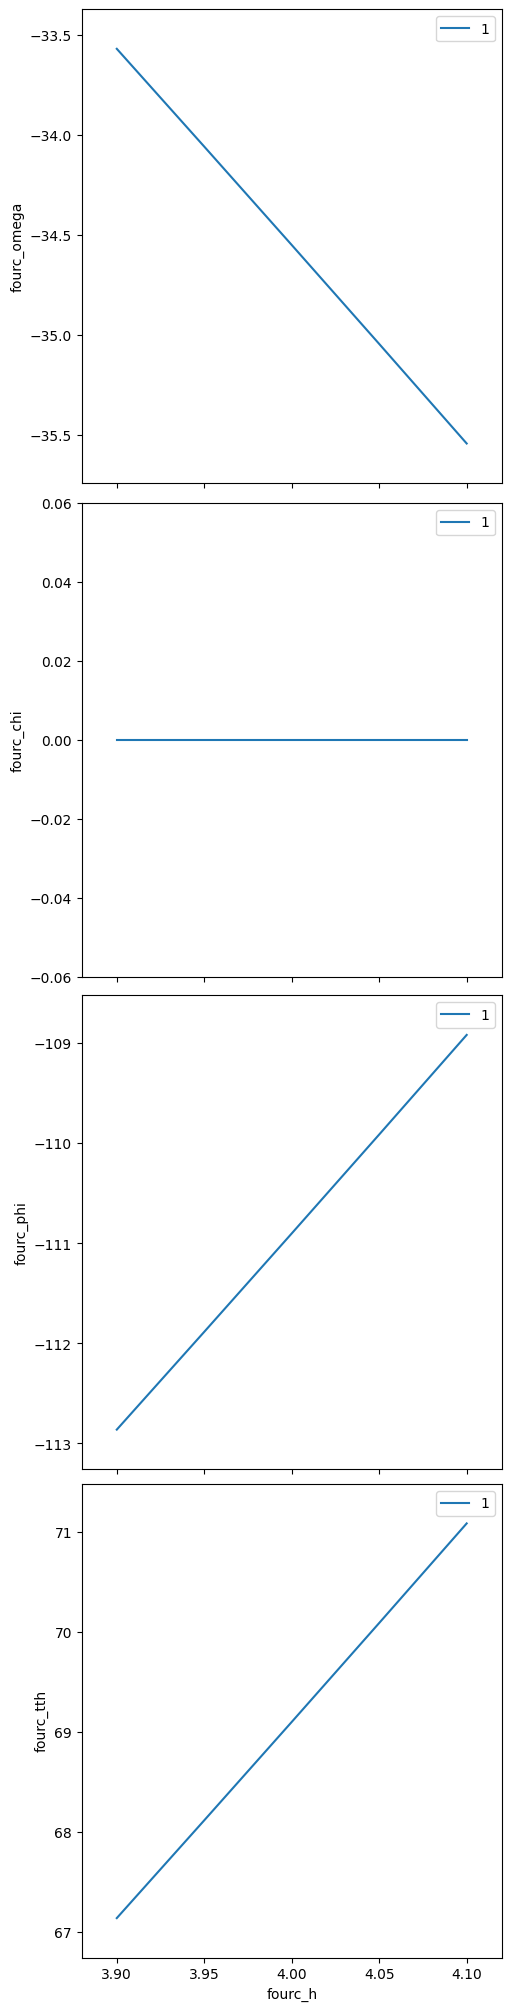

In [18]:
RE(bp.scan([fourc], fourc.h, 3.9, 4.1, fourc.k, 0, 0, fourc.l, 0, 0, 5))

### chi scan from (400) to (040)

If we do this with $\omega=-145.4500$ and $2\theta=69.0985$, this will be a scan between the two orientation reflections.

Use `%mov` (IPython *magic* command) to move both motors at the same time.



Transient Scan ID: 2     Time: 2025-03-11 20:44:31
Persistent Unique Scan ID: '18abc8f0-e78f-40bb-98ff-d6844da7a423'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+-------------+------------+------------+
|   seq_num |       time |  fourc_chi |    fourc_h |    fourc_k |    fourc_l | fourc_omega |  fourc_phi |  fourc_tth |
+-----------+------------+------------+------------+------------+------------+-------------+------------+------------+
|         1 | 20:44:31.9 |      0.000 |     -1.297 |     -0.000 |     -3.784 |    -145.450 |   -108.917 |     69.099 |
|         2 | 20:44:33.2 |     10.000 |     -1.277 |      0.695 |     -3.727 |    -145.450 |   -108.917 |     69.099 |
|         3 | 20:44:34.4 |     20.000 |     -1.219 |      1.368 |     -3.556 |    -145.450 |   -108.917 |     69.099 |
|         4 | 20:44:35.6 |     30.000 |     -1.123 |      2.000 |     -3.277 |    -145.450 |   -108.917 |     69.099 |
|         5 | 20:44:36.8 |

('18abc8f0-e78f-40bb-98ff-d6844da7a423',)

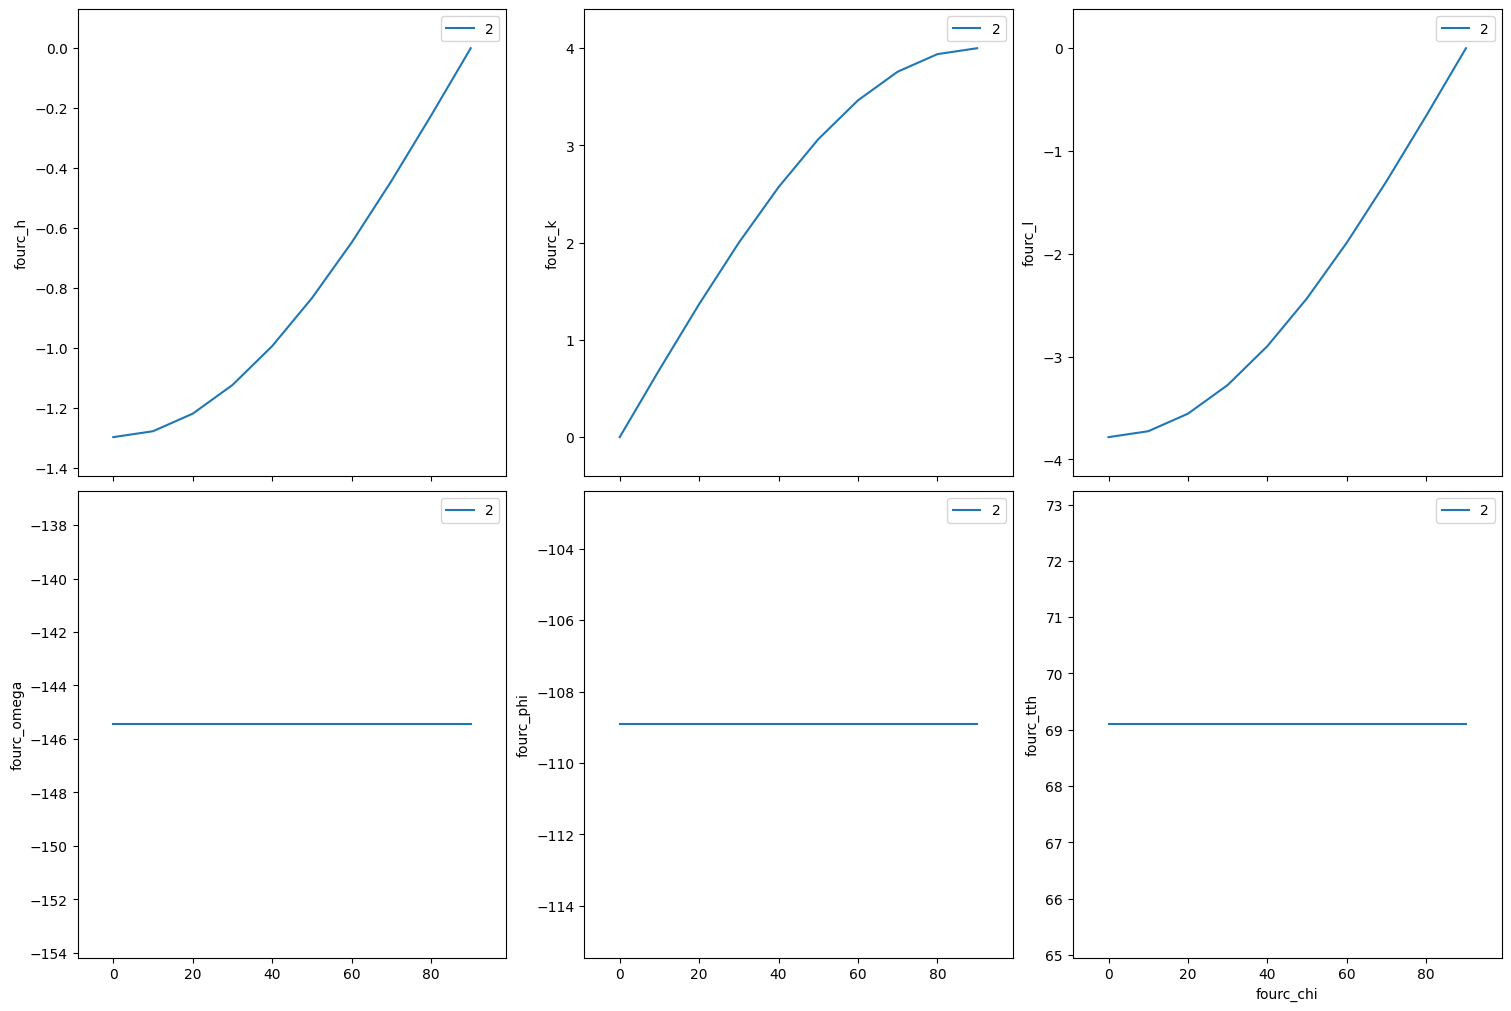

In [19]:
# same as orientation reflections
RE(bps.mv(fourc.omega,-145.4500, fourc.tth,69.0985))

RE(bp.scan([fourc], fourc.chi, 0, 90, 10))

### (_0k0_) scan near (040)



Transient Scan ID: 3     Time: 2025-03-11 20:44:45
Persistent Unique Scan ID: '89324cb2-af12-447e-b0ca-6b8985995ba2'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |    fourc_k |    fourc_h |    fourc_l | fourc_omega |  fourc_chi |  fourc_phi |  fourc_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 20:44:45.7 |      3.900 |      4.100 |     -0.000 |    -126.653 |    136.432 |   -179.999 |    106.695 |
|         2 | 20:44:46.9 |      3.950 |      4.100 |     -0.000 |    -126.180 |    136.067 |   -179.999 |    107.641 |
|         3 | 20:44:48.2 |      4.000 |      4.100 |     -0.000 |    -125.698 |    135.707 |   -179.999 |    108.604 |
|         4 | 20:44:49.4 |      4.050 |      4.100 |      0.000 |    -125.207 |    135.352 |   -179.999 |    109.585 |
|         5 | 20:44:50.7 |

('89324cb2-af12-447e-b0ca-6b8985995ba2',)

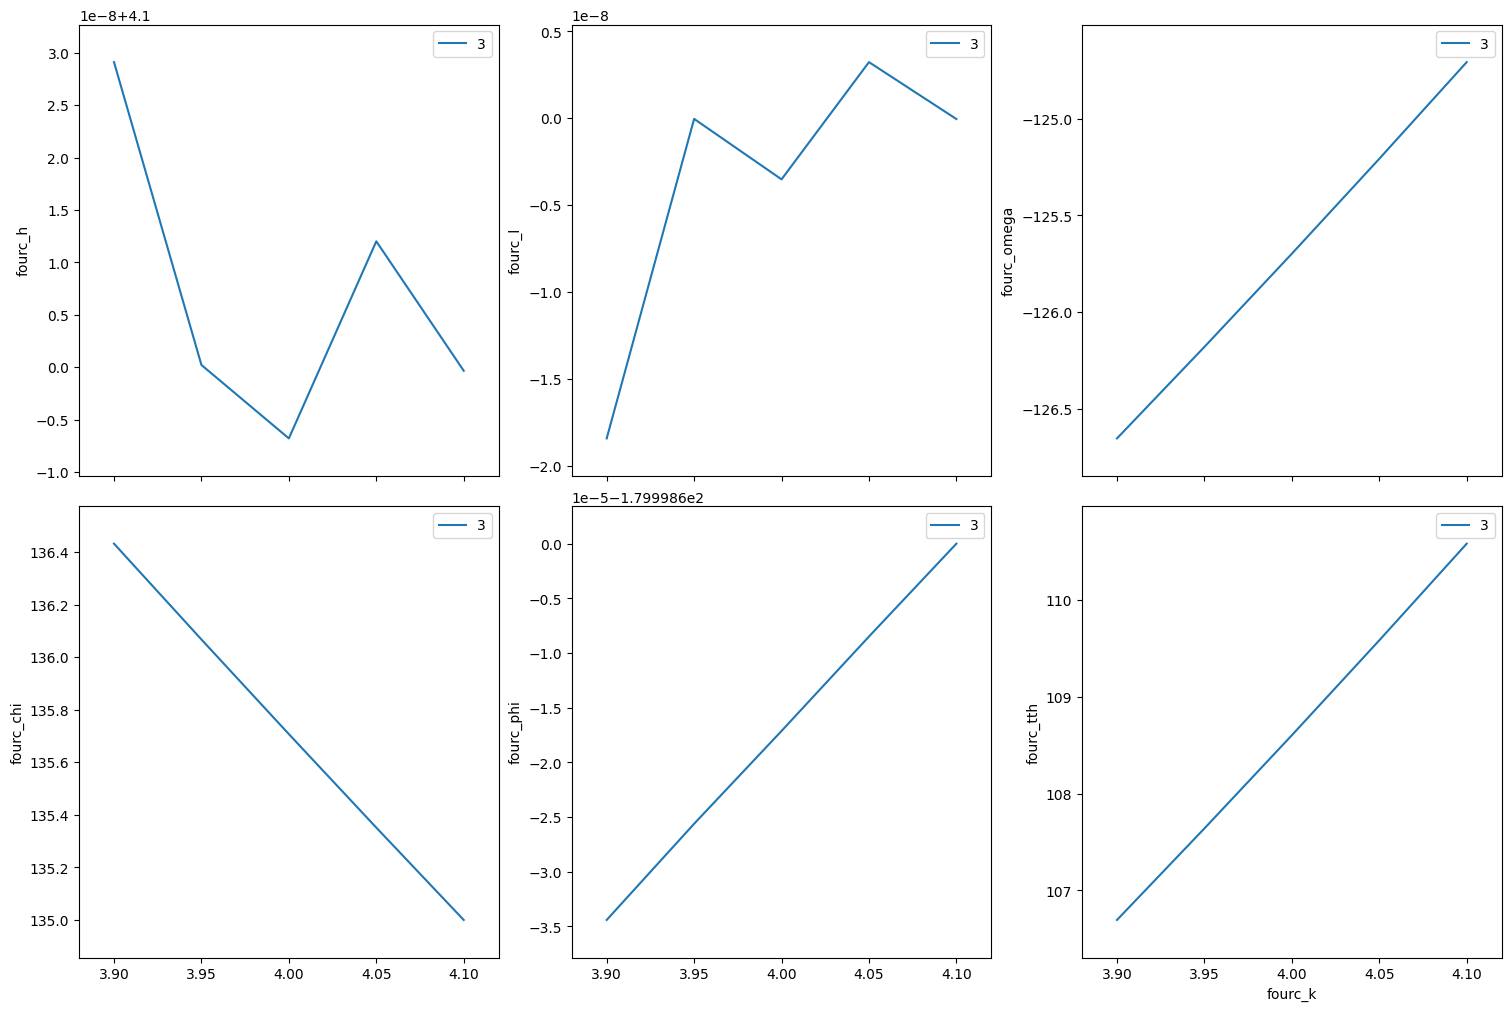

In [20]:
RE(bp.scan([fourc], fourc.k, 3.9, 4.1, 5))

### (_hk0_) scan near (440)



Transient Scan ID: 4     Time: 2025-03-11 20:44:53
Persistent Unique Scan ID: '6e669874-8c2c-492c-a6ff-54d5fb10d1dd'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |    fourc_h |    fourc_k |    fourc_l | fourc_omega |  fourc_chi |  fourc_phi |  fourc_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 20:44:53.5 |      3.900 |      3.900 |      0.000 |    -128.559 |    135.000 |   -179.999 |    102.882 |
|         2 | 20:44:54.4 |      3.950 |      3.950 |      0.000 |    -127.628 |    135.000 |   -179.999 |    104.744 |
|         3 | 20:44:55.3 |      4.000 |      4.000 |     -0.000 |    -126.677 |    135.000 |   -179.999 |    106.647 |
|         4 | 20:44:56.2 |      4.050 |      4.050 |     -0.000 |    -125.704 |    135.000 |   -179.999 |    108.592 |
|         5 | 20:44:57.0 |

('6e669874-8c2c-492c-a6ff-54d5fb10d1dd',)

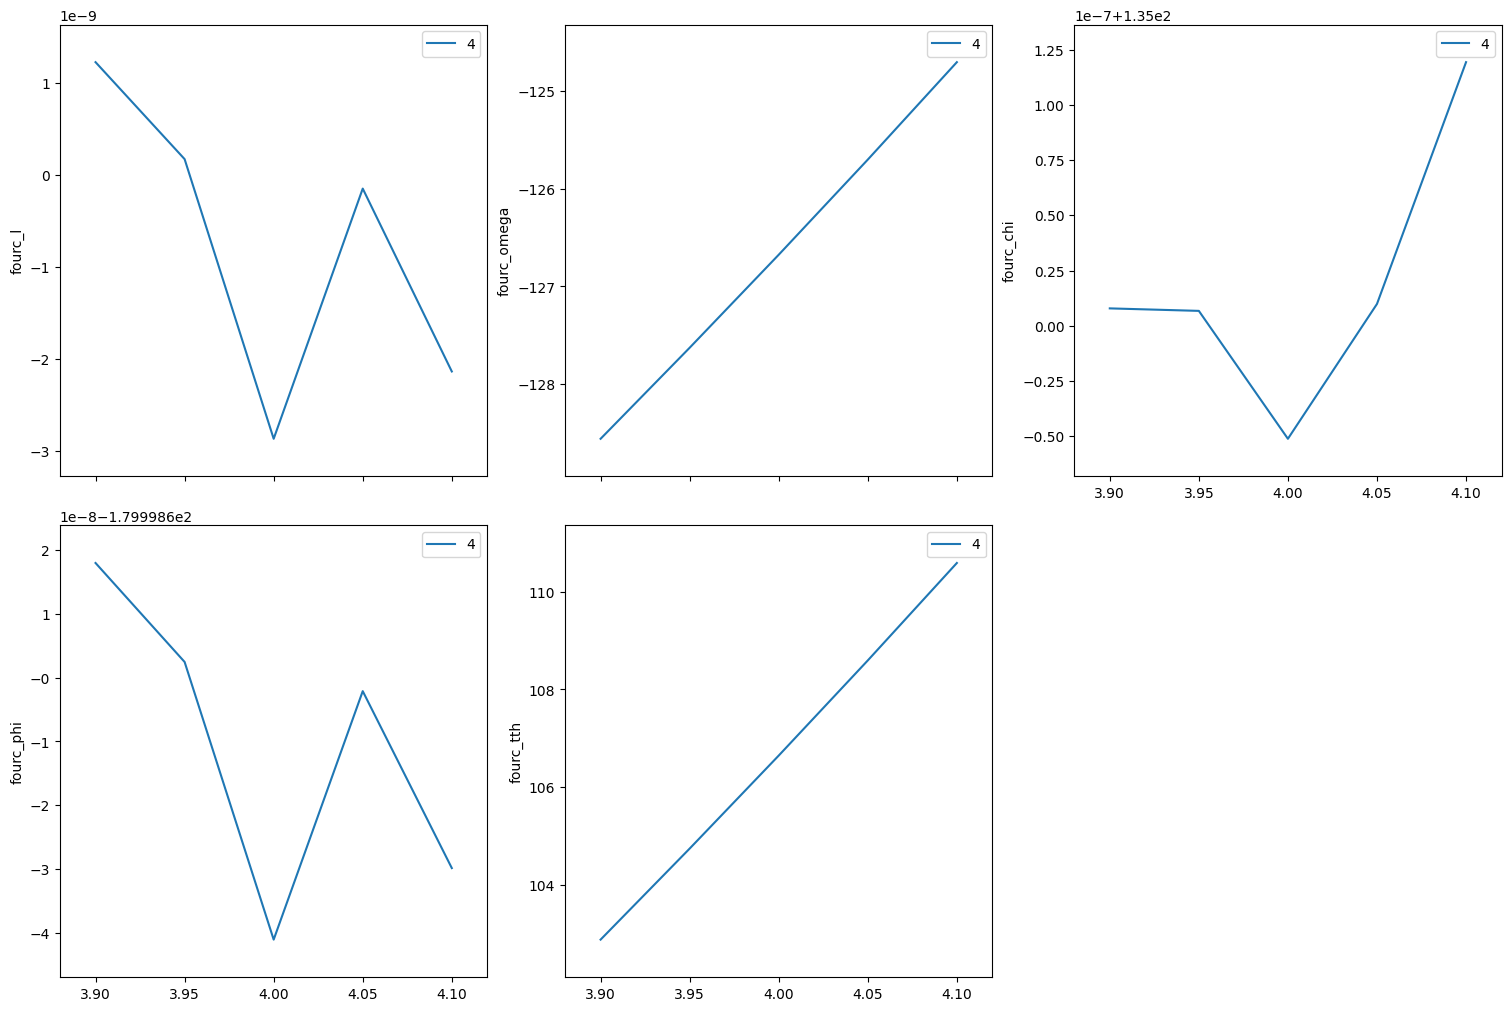

In [21]:
RE(bp.scan([fourc], fourc.h, 3.9, 4.1, fourc.k, 3.9, 4.1, 5))

Move to the (_440_) reflection.

In [22]:
fourc.move((4,4,0))
print(f"{fourc.position = }")

fourc.position = Hklpy2DiffractometerPseudoPos(h=3.999999953592, k=3.999999980506, l=-1.7039e-08)


Repeat the same scan about the (_440_) but use _relative_ positions.



Transient Scan ID: 5     Time: 2025-03-11 20:44:59
Persistent Unique Scan ID: '0258da17-19da-4d7f-88d9-85e60b52a599'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |    fourc_h |    fourc_k |    fourc_l | fourc_omega |  fourc_chi |  fourc_phi |  fourc_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 20:44:59.2 |      3.900 |      3.900 |     -0.000 |    -128.559 |    135.000 |   -179.999 |    102.882 |
|         2 | 20:45:00.1 |      3.950 |      3.950 |     -0.000 |    -127.628 |    135.000 |   -179.999 |    104.744 |
|         3 | 20:45:01.0 |      4.000 |      4.000 |     -0.000 |    -126.677 |    135.000 |   -179.999 |    106.647 |
|         4 | 20:45:01.9 |      4.050 |      4.050 |     -0.000 |    -125.704 |    135.000 |   -179.999 |    108.592 |
|         5 | 20:45:02.8 |

('0258da17-19da-4d7f-88d9-85e60b52a599',)

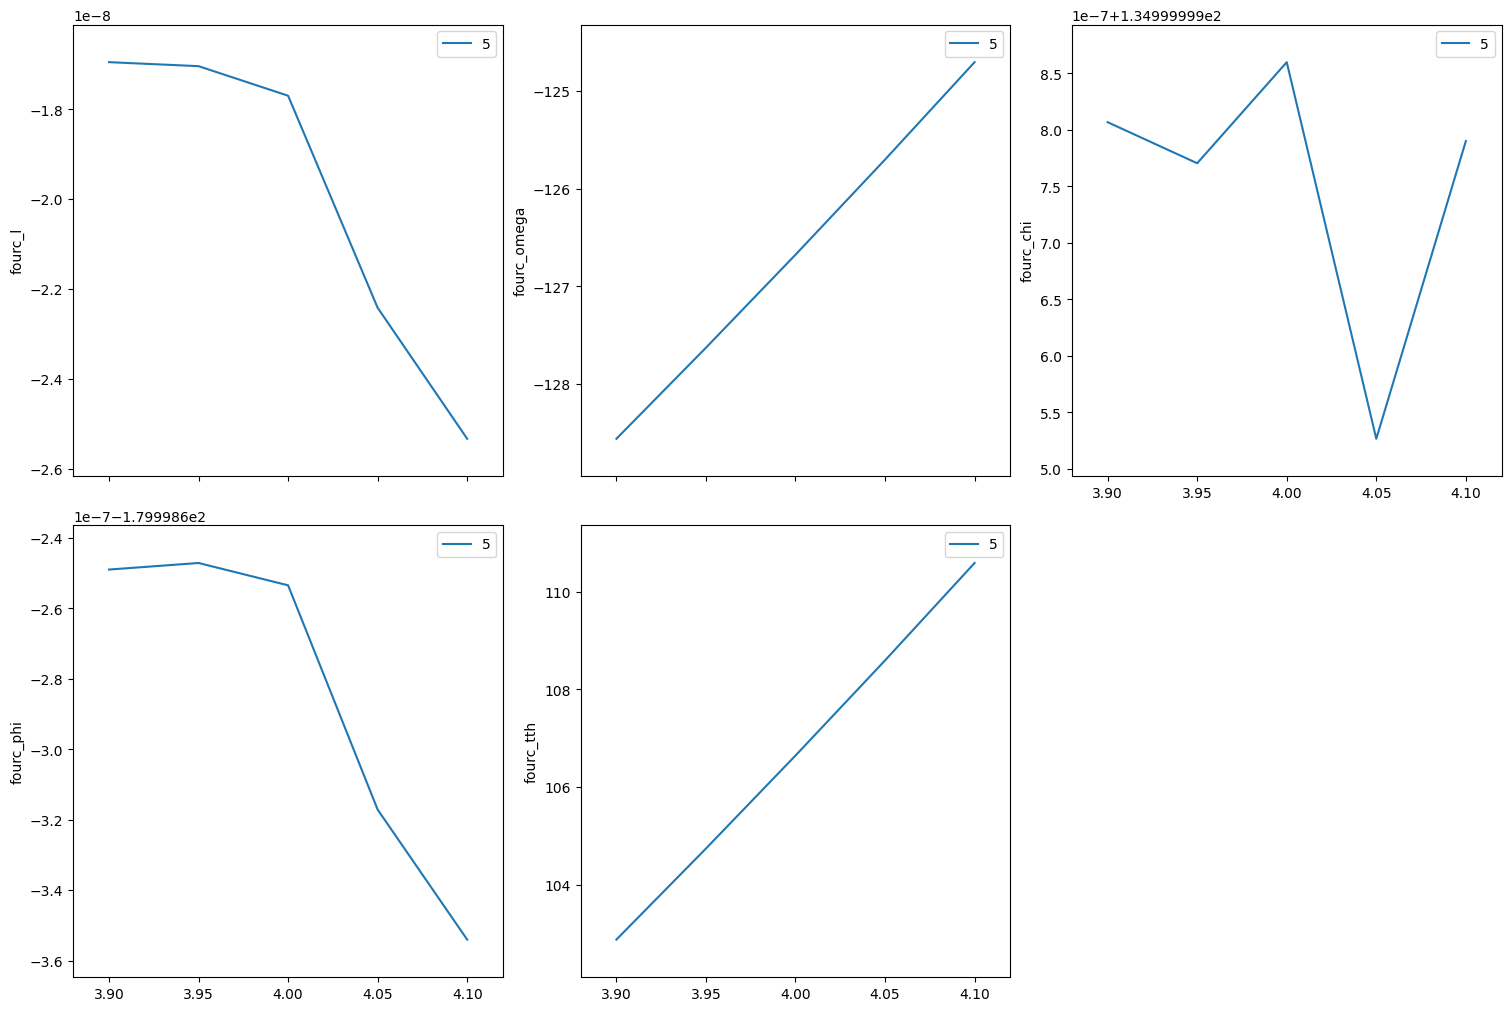

In [23]:
RE(bp.rel_scan([fourc], fourc.h, -0.1, 0.1, fourc.k, -0.1, 0.1, 5))

### Show the configuration

Print the diffractometer configuration that was saved with the run.

In [24]:
cat.v2[-1].start["diffractometers"]["fourc"]

{'_header': {'datetime': '2025-03-11 20:44:59.148373',
  'hklpy2_version': '0.0.28.dev24+gf6d6cff.d20250312',
  'python_class': 'Hklpy2Diffractometer',
  'source_type': 'X-ray',
  'energy_units': 'keV',
  'energy': 8.050921976530415,
  'wavelength_units': 'angstrom',
  'wavelength': 1.54},
 'name': 'fourc',
 'axes': {'pseudo_axes': ['h', 'k', 'l'],
  'real_axes': ['omega', 'chi', 'phi', 'tth'],
  'axes_xref': {'h': 'h',
   'k': 'k',
   'l': 'l',
   'omega': 'omega',
   'chi': 'chi',
   'phi': 'phi',
   'tth': 'tth'},
  'extra_axes': {}},
 'sample_name': 'silicon',
 'samples': {'sample': {'name': 'sample',
   'lattice': {'a': 1,
    'b': 1,
    'c': 1,
    'alpha': 90.0,
    'beta': 90.0,
    'gamma': 90.0},
   'reflections': {},
   'reflections_order': [],
   'U': [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
   'UB': [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
   'digits': 4},
  'silicon': {'name': 'silicon',
   'lattice': {'a': 5.431020511,
    'b': 5.431020511,
    'c': 5.431020511,
    'alpha': 90,
  